In [1]:
import pandas as pd

In [2]:
DATA_DIR = '/Users/asvs/kartheek_hobby_projects/loan_approval_prediction/data'
df_train = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test  = pd.read_csv(f'{DATA_DIR}/test.csv')
df_sub = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

display(df_train.head(1))
print(df_train.shape)
display(df_test.head(1))
print(df_test.shape)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0


(58645, 13)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2


(39098, 12)


In [3]:
df_train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [4]:
CATEGORICAL_COLS = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
NUMERICAL_COLS = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
TARGET_COL = 'loan_status'

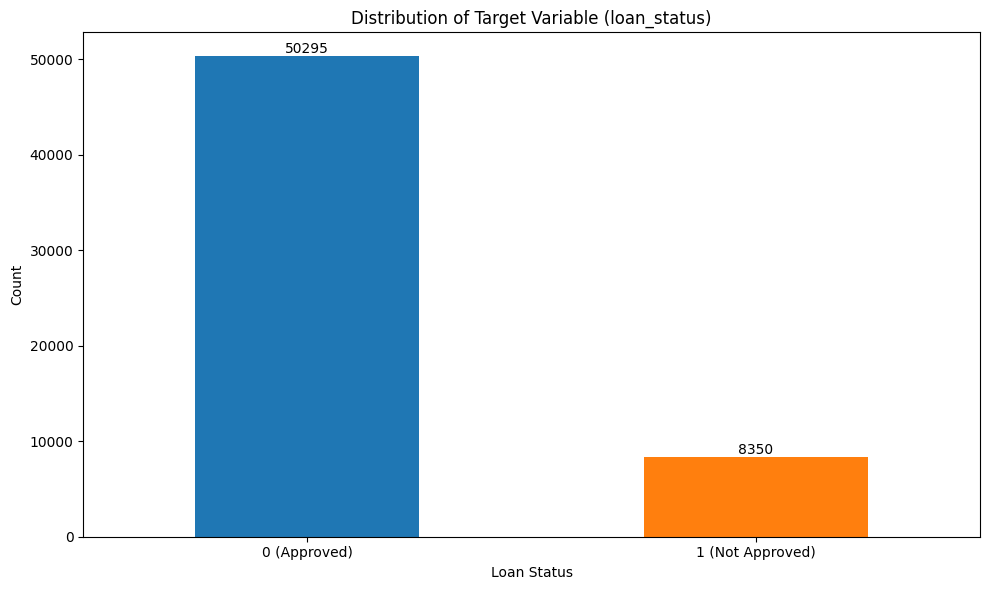

In [6]:
import matplotlib.pyplot as plt

# Count the number of 0s and 1s in the target column
target_counts = df_train[TARGET_COL].value_counts().sort_index()

# Create a bar plot with different colors for each bar
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e']  # Blue for Approved, Orange for Not Approved
target_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Target Variable (loan_status)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['0 (Approved)', '1 (Not Approved)'], rotation=0)

# Add value labels on top of each bar
for i, v in enumerate(target_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## How much is the class imbalance effecting the model performance?


In [8]:
from autogluon.tabular import TabularPredictor
MODEL_PATH = "AutogluonModels/ag-20241002_005121"
predictor = TabularPredictor.load(MODEL_PATH)

CATEGORICAL_COLS = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
NUMERICAL_COLS = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
TARGET_COL = 'loan_status'

def data_preprocessing(df, test=False):
    """
    Preprocess the input DataFrame for AutoGluon training or prediction.

    Args:
        df (pandas.DataFrame): The input DataFrame to preprocess.
        test (bool): Flag indicating whether this is test data (default: False).

    Returns:
        pandas.DataFrame: The preprocessed DataFrame.

    This function performs the following preprocessing steps:
    1. Creates a copy of the input DataFrame to avoid modifying the original.
    2. Drops the 'id' column as it's not required for training or prediction.
    3. Converts categorical columns to 'category' dtype for AutoGluon compatibility.
    4. For training data (test=False), converts the target column to integer type.
    """
    df = df.copy()
    df = df.drop(columns=['id']) # dropping id column as it is not required for training
    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype('category') # type casting categorical columns to category, necessary for AutoGluon
    if not test:
        df[TARGET_COL] = df[TARGET_COL].astype('int') # type casting target column to int.

    return df

mod_df_train = data_preprocessing(df_train)
mod_df_test = data_preprocessing(df_test, test=True)

y_pred_proba = predictor.predict_proba(mod_df_train)[1]
mod_df_train['predicted_proba'] = y_pred_proba
mod_df_train.to_csv('predictions/trainpreds_autogluon_2024-10-02_06-22-24.csv', index=False)

In [12]:
# Calculate performance metrics for each class
from sklearn.metrics import classification_report
import numpy as np

# Separate the data into two classes
class_0 = mod_df_train[mod_df_train[TARGET_COL] == 0]
class_1 = mod_df_train[mod_df_train[TARGET_COL] == 1]

# Combine predictions and true labels
y_true = mod_df_train[TARGET_COL]
y_pred = (mod_df_train['predicted_proba'] > 0.5).astype(int)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Approved Loans', 'Rejected Loans']))

# Overall conclusion
print("\nConclusion:")
report = classification_report(y_true, y_pred, output_dict=True)
if report['0']['f1-score'] > report['1']['f1-score']:
    print("The model is performing better on Class 0 (Approved Loans).")
elif report['0']['f1-score'] < report['1']['f1-score']:
    print("The model is performing better on Class 1 (Rejected Loans).")
else:
    print("The model performance is similar for both classes.")


Classification Report:
                precision    recall  f1-score   support

Approved Loans       0.96      0.99      0.98     50295
Rejected Loans       0.95      0.77      0.85      8350

      accuracy                           0.96     58645
     macro avg       0.96      0.88      0.92     58645
  weighted avg       0.96      0.96      0.96     58645


Conclusion:
The model is performing better on Class 0 (Approved Loans).
